## Imports

In [1]:
import math
import multiprocessing
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.optimize

import modplot
import utils

## Trigger Names

In [2]:
save = True

# trigger names
all_trig_names = ['HLT_Jet30', 'HLT_Jet60', 'HLT_Jet80', 'HLT_Jet110', 'HLT_Jet150', 
                  'HLT_Jet190', 'HLT_Jet240', 'HLT_Jet300', 'HLT_Jet370', 'HLT_Jet800',
                  'HLT_DiJetAve30', 'HLT_DiJetAve60', 'HLT_DiJetAve80', 'HLT_DiJetAve110', 'HLT_DiJetAve150', 
                  'HLT_DiJetAve190', 'HLT_DiJetAve240', 'HLT_DiJetAve300', 'HLT_DiJetAve370', 
                  'HLT_DiJetAve15U', 'HLT_DiJetAve30U', 'HLT_DiJetAve50U', 'HLT_DiJetAve70U',
                  'HLT_DiJetAve100U', 'HLT_DiJetAve140U', 'HLT_DiJetAve180U', 'HLT_DiJetAve300U',
                  'HLT_Jet240_CentralJet30_BTagIP', 'HLT_Jet270_CentralJet30_BTagIP', 'HLT_Jet370_NoJetID']

# single jet triggers
jet_trig_names = all_trig_names[:9]

# trigger colors
trigger_colors = {'HLT_Jet30':  '#999999',
                  'HLT_Jet60':  '#f781bf',
                  'HLT_Jet80':  '#a65628',
                  'HLT_Jet110': '#99cc00',
                  'HLT_Jet150': '#ff7f00',
                  'HLT_Jet190': '#984ea3',
                  'HLT_Jet240': '#4daf4a',
                  'HLT_Jet300': '#377eb8',
                  'HLT_Jet370': '#e41a1c'}

## LumiBlocks

In [3]:
# get the list of valid lumiblocks
lbs = np.load(utils.path('cms', 'lumis/ValidatedLumiblocks.pickle'), allow_pickle=True)
rnlbs = sorted(lbs.keys())

In [4]:
# get some convenient arrays for later
times = np.asarray([lbs[rnlb]['time'] for rnlb in rnlbs])
rec_lumis = np.asarray([lbs[rnlb]['rec_lumi'] for rnlb in rnlbs])
del_lumis = np.asarray([lbs[rnlb]['del_lumi'] for rnlb in rnlbs])
nevs = np.asarray([lbs[rnlb]['nev'] for rnlb in rnlbs])

In [5]:
# dictionary to hold trigger info for each lumi block
trigs = {trig: {'nlb': 0, 'counts': [], 'prescales': []} for trig in all_trig_names}

# iterate over lumiblocks
for i,rnlb in enumerate(rnlbs):
    
    # get lumi block and determine if it has nonzero recorded luminosity
    lb = lbs[rnlb]
    has_rec_lumi = rec_lumis[i] > 0.
    
    # add inds lookup to lb
    lb['names2inds'] = {n: i for i,n in enumerate(lb['triggers'])}
    
    # iterate over trigger dictionary
    for name,cur_trig in trigs.items():
        
        # if valid and trigger was present
        if has_rec_lumi and name in lb['triggers']:
            
            # determine position of trigger in lumiblock
            i0 = lb['names2inds'][name]
            
            # append info
            cur_trig['nlb'] += 1
            cur_trig['counts'].append(lb['counts'][i0])
            cur_trig['prescales'].append(lb['prescales'][i0])
            
        # trigger was not present
        else:
            cur_trig['counts'].append(0)
            cur_trig['prescales'].append(-1)

# make counts and prescales into numpy arrays
for trig,cur_trig in trigs.items():
    cur_trig['counts'] = np.asarray(cur_trig['counts'])
    cur_trig['prescales'] = np.asarray(cur_trig['prescales'])

## Table 1

In [6]:
def make_table1(out=None):

    # format table 1
    table_1 = ['equals', 'cols', 'equals',
                 'HLT_Jet30', 'HLT_Jet60', 'HLT_Jet80', 'HLT_Jet110', 'HLT_Jet150', 
                 'HLT_Jet190', 'HLT_Jet240', 'HLT_Jet300', 'HLT_Jet370', 'HLT_Jet800',
               'hline',
                 'HLT_DiJetAve30', 'HLT_DiJetAve60', 'HLT_DiJetAve80', 'HLT_DiJetAve110', 'HLT_DiJetAve150', 
                 'HLT_DiJetAve190', 'HLT_DiJetAve240', 'HLT_DiJetAve300', 'HLT_DiJetAve370', 
               'hline',
                 'HLT_DiJetAve15U', 'HLT_DiJetAve30U', 'HLT_DiJetAve50U', 'HLT_DiJetAve70U',
                 'HLT_DiJetAve100U', 'HLT_DiJetAve140U', 'HLT_DiJetAve180U', 'HLT_DiJetAve300U',
               'hline',
                 'HLT_Jet240_CentralJet30_BTagIP', 'HLT_Jet270_CentralJet30_BTagIP', 'HLT_Jet370_NoJetID',
               'equals']

    leff_dict = {}
    for name in table_1:
        if name == 'hline':
            print(100*'-', file=out)
        elif name == 'equals':
            print(100*'=', file=out)
        elif name == 'cols':
            cols = ('Trigger Name', 'LBs', 'Events', 'Fireds', 'L_eff [nb^-1]', '<p^trig>', 'sigma_eff [nb]')
            print('{:30}{:>10}{:>10}{:>9}{:>15}{:>10}{:>16}'.format(*cols), file=out)
        else:
            cur_trig = trigs[name]

            # get mask for when trigger is present
            mask = (cur_trig['prescales'] > 0)

            # add effective luminosity information (in 1/nb) per lumiblock to trigger dictionary 
            cur_trig['leffs'] = rec_lumis[mask]/cur_trig['prescales'][mask]/10**3

            # total effective luminosity
            leff = np.sum(cur_trig['leffs'])
            leff_dict[name] = leff

            # average prescale
            pavg = np.sum(rec_lumis[mask])/leff/10**3

            # number fired
            fired = int(np.sum(cur_trig['counts']))

            # format printing
            vals = (name, cur_trig['nlb'], nevs[mask].sum(), fired, leff, pavg, fired/leff)
            print('{:30}{:>10}{:>10}{:>9}{:>15.3f}{:>10.1f}{:>16.3f}'.format(*vals), file=out)
           
    if out is None:
        return leff_dict

# for printing here
leff_dict = make_table1()
leff_dict['units'] = 'nb^-1'

if save:
    with open('../plots/Triggers/Table_1.txt', 'w') as f:
        make_table1(out=f)
        
    leff_filepath = utils.path('cms', 'lumis/EffectiveLuminositiesByTrigger.pickle')
    with open(leff_filepath, 'wb') as f:
        pickle.dump(leff_dict, f)

Trigger Name                         LBs    Events   Fireds  L_eff [nb^-1]  <p^trig>  sigma_eff [nb]
HLT_Jet30                         109196  26254892  1884768         12.567  185672.6      149981.925
HLT_Jet60                         109196  26254892  1829490        293.986    7936.7        6223.060
HLT_Jet80                         102304  24742482  1512638        901.352    2293.8        1678.188
HLT_Jet110                        109196  26254892  2212878       6172.430     378.0         358.510
HLT_Jet150                        102304  24742482  2616716      33521.114      61.7          78.062
HLT_Jet190                        109196  26254892  2715282     114843.687      20.3          23.643
HLT_Jet240                        109196  26254892  2806220     392659.479       5.9           7.147
HLT_Jet300                         98462  22788815  4616184    2284792.618       1.0           2.020
HLT_Jet370                        109196  26254892  1514305    2333280.071       1.0       

### Time Order Luminosity Blocks

In [7]:
# iterate over triggers
for name,cur_trig in trigs.items():
    
    # mask of when trigger was present
    mask = (cur_trig['prescales'] > 0)
    
    # time sorting of lumi blocks
    time_argsort = np.argsort(times[mask])
    
    # effective luminosities ordered by time
    cur_trig['leffs_ordered'] = cur_trig['leffs'][time_argsort]
    
    # effective cross sections ordered by time 
    cur_trig['sigmaeffs_ordered'] = cur_trig['counts'][mask][time_argsort]/(cur_trig['leffs_ordered'] + 10**-30)
    
    # time ordered indices of blocks that are present
    cur_trig['indices'] = np.arange(len(mask))[mask]

## Time Ordered Luminosity Plot

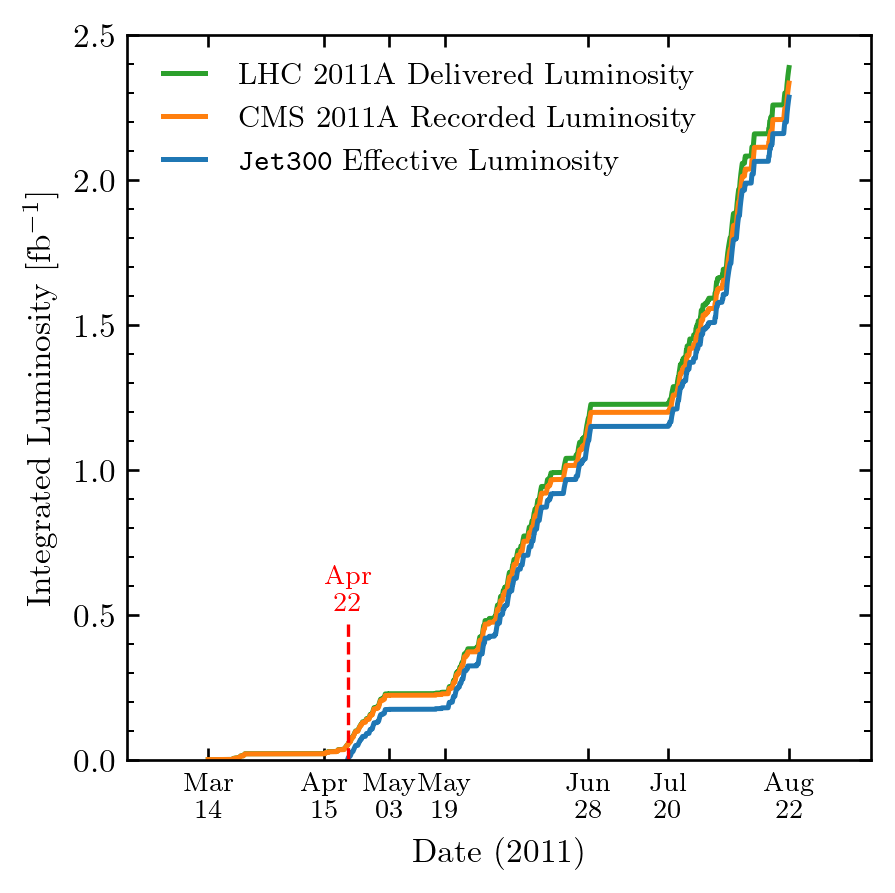

In [8]:
unitsf = 10**9

fig, [ax] = modplot.axes(ratio_plot = False, xlim=(.9985*min(times), 1.0015*max(times)), 
                         ylim=(0, 2.5), xlabel='Date (2011)', ylabel='Integrated Luminosity [fb$^{-1}$]', 
                         xticks=[])

ax.plot(times, np.cumsum(del_lumis/10**9), '-', ms=2,
             label='LHC 2011A Delivered Luminosity', color='tab:green')
ax.plot(times, np.cumsum(rec_lumis/10**9), '-', ms=2,
             label='CMS 2011A Recorded Luminosity', color='tab:orange')

inds, leffs = trigs['HLT_Jet300']['indices'], trigs['HLT_Jet300']['leffs_ordered']
ax.plot(times[inds], np.cumsum(leffs)/10**6, '-', ms=2, 
        label=r'{\tt Jet300} Effective Luminosity', color='tab:blue')

ax.set_xticks([min(times), max(times), 1305763200, 1304431410, 1311120000, 1309219200, 1302866383])
ax.set_xticklabels(['Mar\n14', 'Aug\n22', 'May\n19', 'May\n03', 'Jul\n20', 'Jun\n28', 'Apr\n15'])
ax.tick_params(axis='x', which='minor', bottom=False, top=False)

modplot.legend(loc='upper left', prop={'size': 9})

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(8) 

jet300start = np.min(times[inds])
ax.plot([jet300start, jet300start], [0, 0.48], '--', lw=1, color='red')
ax.text(jet300start - 100, 0.48*1.075, 'Apr\n22', horizontalalignment='center', size=8, color='red')

# save plot
if save:
    modplot.save(fig, 'IntegratedLuminosity', tx=37.2, ty=258.5, out_plots_dir='../plots/Triggers/')

fig.show()

## Effective Luminosity Plot

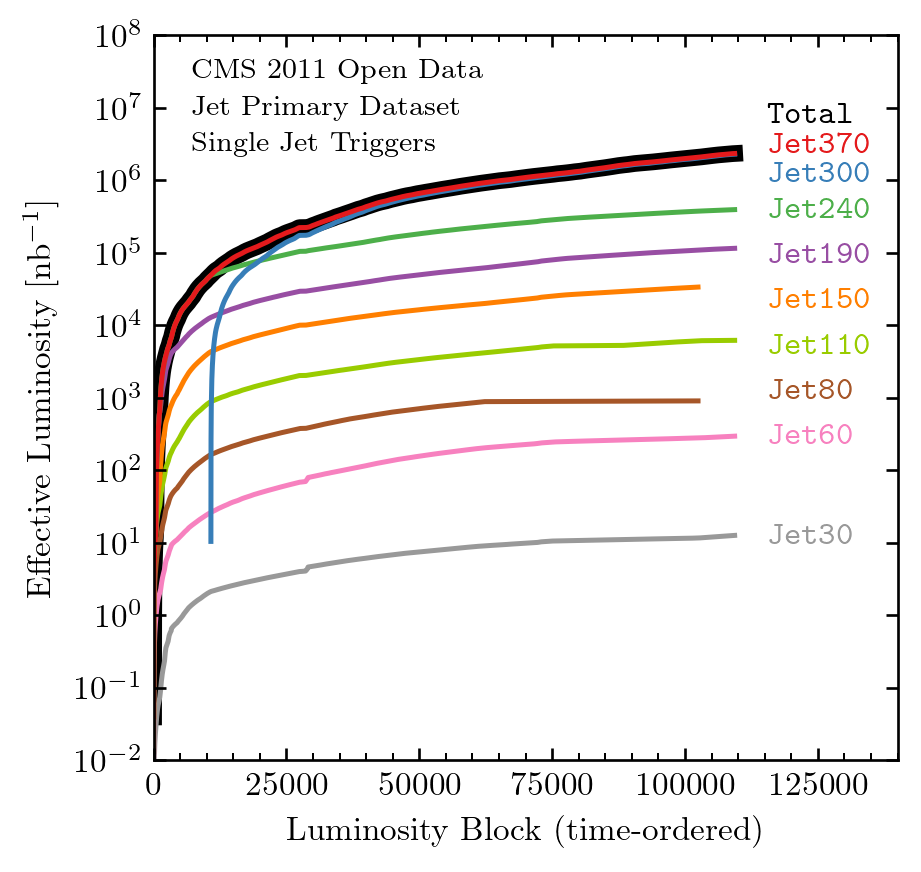

In [9]:
fig, axes = modplot.axes(ratio_plot=False, 
                         xlabel='Luminosity Block (time-ordered)', 
                         ylabel=r'Effective Luminosity [nb$^{-1}$]',
                         xlim=(0, 140000),
                         xtick_step=25000)
ax = axes[0]

ax.set_yscale('log')
ax.set_ylim(10**-2, 10**8)
ax.set_yticks(10.**np.arange(-2, 9))

# iterate over single jet triggers
jtn_reversed = jet_trig_names[::-1]
for i,name in enumerate(jtn_reversed):
    cur_trig = trigs[name]
    
    # plot cumulative effective luminsoity
    ax.plot(cur_trig['indices'], np.cumsum(cur_trig['leffs_ordered']), '-', zorder=-i,
             color=trigger_colors[name])

cur_trig = trigs['HLT_Jet370']
ax.plot(cur_trig['indices'], np.cumsum(cur_trig['leffs_ordered']), '-', lw=5, zorder=-20, color='black')

x = 0.825
modplot.stamp(x, 0.89, line_0=r'\tt Total', line_1=None, ax=ax,
              textops_update={'color': 'black', 'fontsize': 10})

y, delta_y = 0.85, 0.04
for i,name in enumerate(jtn_reversed[:2]):
    modplot.stamp(x, y - i*delta_y, line_0=r'\tt {}'.format(name[4:]), line_1=None, ax=ax,
                  textops_update={'color': trigger_colors[name], 'fontsize': 10})
    
y, delta_y = 0.76, 0.0625
for i,name in enumerate(jtn_reversed[2:-1]):
    modplot.stamp(x, y - i*delta_y, line_0=r'\tt {}'.format(name[4:]), line_1=None, ax=ax,
                  textops_update={'color': trigger_colors[name], 'fontsize': 10})
    
modplot.stamp(x, 0.31, line_0=r'\tt Jet30', line_1=None, ax=ax,
                  textops_update={'color': trigger_colors['HLT_Jet30'], 'fontsize': 10})

modplot.stamp(0.05, 0.95, delta_y=0.05,
              line_0='CMS 2011 Open Data', 
              line_1='Jet Primary Dataset', 
              line_2='Single Jet Triggers')

if save:
    modplot.save(fig, 'CMS_EffectiveLuminositiesByLumiBlock', 
                 tx=45, ty=252.5, out_plots_dir='../plots/Triggers')

fig.show()

## Effective Cross Section Plot

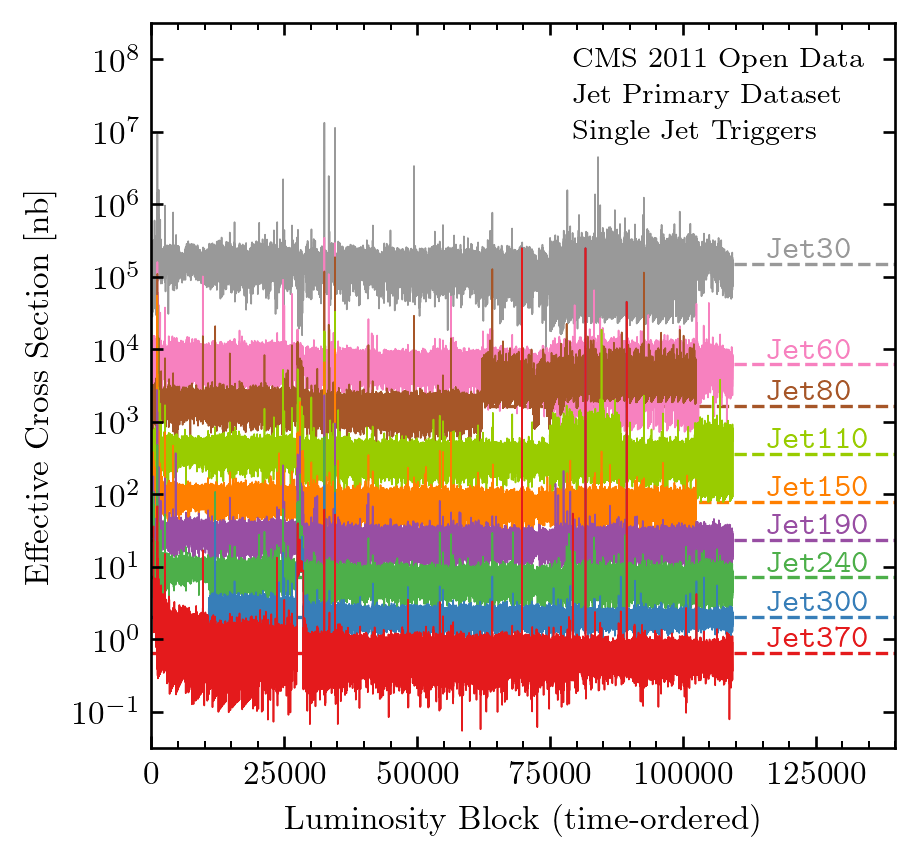

In [10]:
fig, axes = modplot.axes(ratio_plot=False, 
                         xlabel='Luminosity Block (time-ordered)',
                         ylabel='Effective Cross Section [nb]',
                         xlim=(0, 140000),
                         xtick_step=25000)

ax = axes[0]

ax.set_yscale('log')
ax.set_ylim(10**-1.5, 10**8.5)
ax.set_yticks(10.**np.arange(-1, 9))

# iterate over single jet triggers
for i,name in enumerate(jet_trig_names[::-1]):
    cur_trig = trigs[name]
    color = trigger_colors[name]
    
    # non-zero make
    nz_mask = (cur_trig['sigmaeffs_ordered'] > 0)
    
    # plot average effective cross section
    avg_eff_xs = np.sum(cur_trig['counts'])/np.sum(cur_trig['leffs'])
    ax.plot([0, 140000], 2*[avg_eff_xs], '--', lw=1, color=color, zorder=-20)
    
    # plot effective cross section by lumi block
    ax.plot(cur_trig['indices'][nz_mask], cur_trig['sigmaeffs_ordered'][nz_mask], '-', lw=0.5, 
             color=color, zorder=-i)
    
    # jet label
    ax.text(115500, avg_eff_xs*1.6, r'\tt {}'.format(name[4:]), 
            horizontalalignment='left', verticalalignment='center', fontsize=10, color=color)

modplot.stamp(0.565, 0.95, delta_y=0.05,
              line_0='CMS 2011 Open Data', 
              line_1='Jet Primary Dataset', 
              line_2='Single Jet Triggers')

if save:
    modplot.save(fig, 'CMS_EffectiveCrossSectionByLumiBlock', 
                 tx=44.3, ty=252.5, out_plots_dir='../plots/Triggers')
    
fig.show()

## Single Jet Triggers by pT

In [18]:
def triggers_by_pt(filepath, dataset='cms'):
    
    # containers
    fireds, prescales, jet_pts = [], [], []
    
    # load file
    f = np.load(filepath, allow_pickle=True)
    
    # get lumiblocks for this file
    f_lbs = f['lbs']
    for lb in f_lbs:
        lb_triggers, lb_prescales = lb['triggers'], lb['prescales']
        
        # the indices where the jet triggers are for this lumi block, -1 if not present
        lb['jtn_inds'] = np.asarray([lb_triggers.index(name) if name in lb_triggers else -1 
                                     for name in jet_trig_names])
        
        # the prescales for the jet triggers in this lumi block, -1 if not present
        lb['jtn_prescales'] = np.asarray([lb_prescales[jtn_i] if jtn_i != -1 else -1 
                                          for jtn_i in lb['jtn_inds']])
        
        # rnlb
        lb['rnlb'] = (lb['rn'], lb['lb'])
        
    cms = (dataset == 'cms')
    
    # iterate over events in file
    for lb_i,ak5s,ftrig in zip(f['lbs_i'], f['ak5s'], f['ftrigs']):
        
        # skip if no jets
        if not len(ak5s):
            continue
        
        # get lumiblock for this event
        lb = f_lbs[lb_i]
        
        # skip if invalid
        if cms:
            if lb['rnlb'] not in lbs or lbs[lb['rnlb']]['rec_lumi'] == 0.:
                continue
        
        # apply JECs
        pts_corrected = ak5s[:,1] * ak5s[:,5]
        argsort = np.argsort(pts_corrected)[::-1]
        
        # iterate over hardest jet
        n = 0
        for i in argsort[:1]:
            
            # get jet
            ak5 = ak5s[i]
            
            # get proper pt and eta
            pt = pts_corrected[i]

            # impose medium quality and eta cut
            if ak5[13] < 2 or abs(ak5[2]) >= 1.9:
                continue

            # append jet pt
            jet_pts.append(pt)
            
            # increase counter
            n += 1
            
        # if we got any jets from this event
        if n > 0:
            
            # determine if triggers fired
            ak5_fireds = np.isin(lb['jtn_inds'], ftrig, assume_unique=True)

            # append fireds and prescales the correct number of times
            if n == 1:
                fireds.append(ak5_fireds)
                prescales.append(lb['jtn_prescales'])
            elif n == 2:
                fireds.extend(2*[ak5_fireds])
                prescales.extend(2*[lb['jtn_prescales']])
                
    return fireds, prescales, jet_pts

def sim_triggers_by_pt(filepath):
    return triggers_by_pt(filepath, dataset='sim')

### CMS Triggers by pT

In [19]:
# iterate over files containing jet info
start = time.time()
filepaths = utils.get_filenames(subdir='pickle', include_path=True, must_include='noparticles')

# containers
fireds, prescales, jet_pts = [], [], []
with multiprocessing.Pool(processes=24) as pool:
    for i,rs in enumerate(pool.imap_unordered(triggers_by_pt, filepaths, chunksize=1)):
        if (i+1) % 100 == 0:
            print('[{}/{}] files processed in {:.3f}s'.format(i+1, len(filepaths), time.time() - start))
            
        fireds.extend(rs[0])
        prescales.extend(rs[1])
        jet_pts.extend(rs[2])

# make numpy arrays
fireds = np.asarray(fireds, dtype=bool)
prescales = np.asarray(prescales, dtype=int)
jet_pts = np.asarray(jet_pts, dtype=float)

# save numpy arrays
if save:
    fp = utils.path('cms', 'plotdata/TriggersByPtHardestJet.npz')
    print('Saved to', fp)
    np.savez_compressed(fp, fireds=fireds, prescales=prescales, jet_pts=jet_pts)

[100/1223] files processed in 10.668s
[200/1223] files processed in 16.807s
[300/1223] files processed in 23.090s
[400/1223] files processed in 29.185s
[500/1223] files processed in 35.253s
[600/1223] files processed in 41.667s
[700/1223] files processed in 47.881s
[800/1223] files processed in 53.738s
[900/1223] files processed in 59.420s
[1000/1223] files processed in 64.850s
[1100/1223] files processed in 70.219s
[1200/1223] files processed in 75.519s
Saved to /disk0/CMS2011AJets/JetPrimaryDataset/plotdata/TriggersByPtHardestJet.npz


## CMS Effective Cross Section by pT

In [45]:
# load in saved trigger info
trigsbypt = np.load(utils.path('cms', 'plotdata/TriggersByPtHardestJet.npz'))
fireds, jet_pts = trigsbypt['fireds'], trigsbypt['jet_pts']

In [46]:
bins = np.linspace(0, 800, 81)
midbins = (bins[1:] + bins[:-1])/2
binwidth = bins[1] - bins[0]

eff_xs_hists = {}
for i,name in enumerate(jet_trig_names):
    hist, errs, bins = modplot.calc_hist(jet_pts[fireds[:,i]], bins=bins, density=False)
    eff_xs_hists[name] = (hist, errs)

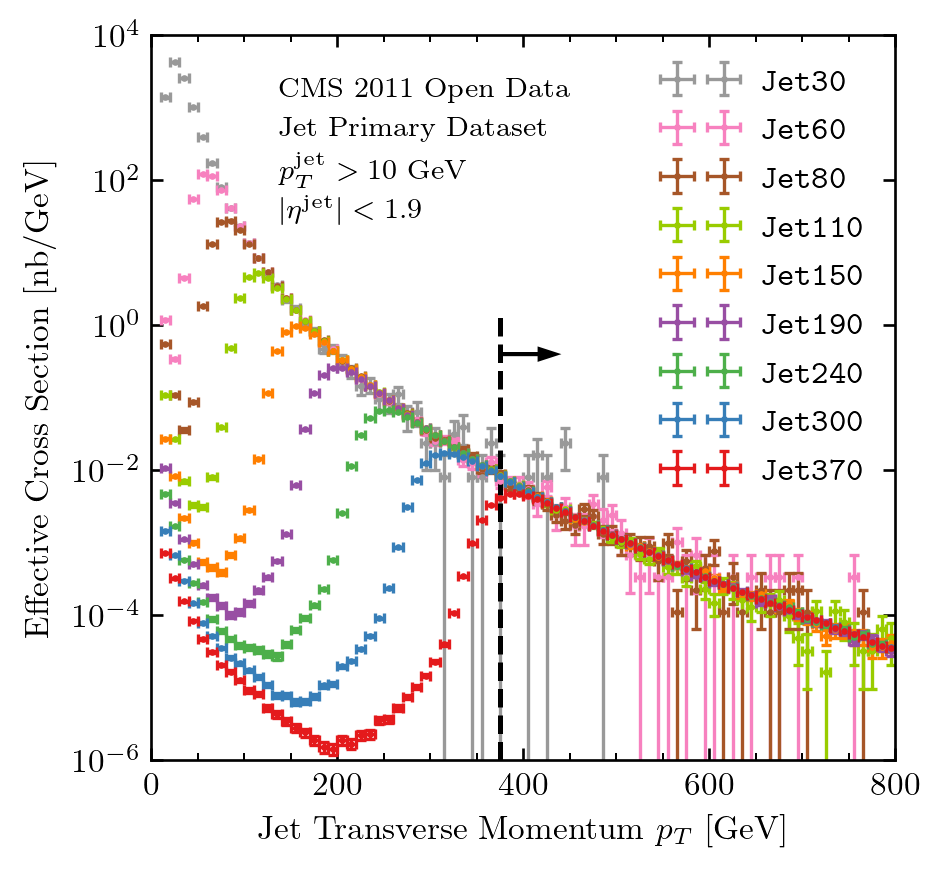

In [47]:
fig, axes = modplot.axes(ratio_plot=False, 
                         xlim=(min(bins), max(bins)), ylim=(10**-6, 10**4),
                         xlabel=r'Jet Transverse Momentum $p_T$ [GeV]',
                         ylabel='Effective Cross Section [nb/GeV]')
ax = axes[0]
ax.set_yscale('log')

for i,name in enumerate(jet_trig_names):
    hist, errs = eff_xs_hists[name]
    
    c = np.sum(trigs[name]['leffs'])*binwidth
    
    ax.errorbar(midbins, hist/c, xerr=binwidth/2, yerr=errs/c,
                marker='o', ms=1, ls='none', elinewidth=1, capthick=1, capsize=1.5,
                label=r'\tt {}'.format(name[4:]), color=trigger_colors[name])

ax.plot([375,375], [10**-6, 1.3], color='black', ls='--')
ax.arrow(375/800, 0.56, 0.075, 0, transform=ax.transAxes,
         length_includes_head=True, head_width=0.015, color='black')
    
# legend
ax.legend(loc='upper right', frameon=False, ncol=1, numpoints=2)

# stamp
modplot.stamp(0.17, 0.925, delta_y=0.055,
              line_0='CMS 2011 Open Data', 
              line_1='Jet Primary Dataset', 
              line_2=r'$p_T^{\rm jet}>10$ GeV',
              line_3=r'$|\eta^{\rm jet}|<1.9$')

if save:
    modplot.save(fig, 'CMS_EffectiveCrossSectionByPtHardestJet', 
                 tx=44.5, ty=252, out_plots_dir='../plots/Triggers')

fig.show()

### SIM Triggers by pT

In [24]:
# get all filepaths for sim datasets
sim_filepaths = utils.get_sim_filenames_dict(subdir='pickle', include_path=True, must_include='noparticles')

# iterate over sim datasets
sim_trs = {}
for ptmin in sim_filepaths.keys():
    sim_trs[ptmin] = {}

    # iterate over files containing jet info
    start = time.time()
    with multiprocessing.Pool(processes=36) as pool:
        print('SIM', ptmin)
        
        # parallelize extracting the trigger info
        sim_trs[ptmin]['fireds'], sim_trs[ptmin]['prescales'], sim_trs[ptmin]['jet_pts'] = [], [], []
        filepaths = sim_filepaths[ptmin]
        for i,rs in enumerate(pool.imap_unordered(sim_triggers_by_pt, filepaths, chunksize=1)):
            if (i+1) % 100 == 0:
                print('  [{}/{}] files processed in {:.3f}s'.format(i+1, len(filepaths), time.time() - start))

            sim_trs[ptmin]['fireds'].extend(rs[0])
            sim_trs[ptmin]['prescales'].extend(rs[1])
            sim_trs[ptmin]['jet_pts'].extend(rs[2])
            
        sim_trs[ptmin]['fireds'] = np.asarray(sim_trs[ptmin]['fireds'])
        sim_trs[ptmin]['prescales'] = np.asarray(sim_trs[ptmin]['prescales'])
        sim_trs[ptmin]['jet_pts'] = np.asarray(sim_trs[ptmin]['jet_pts'])
        
    # print progress
    print('Finished with ptmin {} in {:.3f}s'.format(ptmin, time.time() - start))
    print()
    
if save:
    fp = utils.path('sim', 'plotdata/TriggersByPtHardestJet.pickle')
    print('Saved to', fp)
    with open(fp, 'wb') as f:
        pickle.dump(sim_trs, f)

SIM 120
  [100/334] files processed in 17.035s
  [200/334] files processed in 20.547s
  [300/334] files processed in 23.793s
Finished with ptmin 120 in 29.882s

SIM 170
  [100/387] files processed in 13.970s
  [200/387] files processed in 17.721s
  [300/387] files processed in 21.286s
Finished with ptmin 170 in 29.810s

SIM 300
  [100/382] files processed in 14.478s
  [200/382] files processed in 18.026s
  [300/382] files processed in 21.487s
Finished with ptmin 300 in 29.620s

SIM 470
  [100/274] files processed in 14.753s
  [200/274] files processed in 18.539s
Finished with ptmin 470 in 24.939s

SIM 600
  [100/271] files processed in 15.771s
  [200/271] files processed in 19.809s
Finished with ptmin 600 in 27.055s

SIM 800
  [100/295] files processed in 16.665s
  [200/295] files processed in 21.418s
Finished with ptmin 800 in 29.812s

SIM 1000
  [100/131] files processed in 17.392s
Finished with ptmin 1000 in 21.382s

SIM 1400
  [100/182] files processed in 15.847s
Finished with ptmi

## SIM Effective Cross Section by pT

In [48]:
sim_trs = np.load(utils.path('sim', 'plotdata/TriggersByPtHardestJet.pickle'), allow_pickle=True)

In [49]:
bins = np.linspace(0, 2500, 101)
midbins = (bins[1:] + bins[:-1])/2
binwidth = bins[1] - bins[0]

sim_xs = np.load(utils.path('sim', 'CrossSections.pickle'), allow_pickle=True)

eff_xs_hists = {}
for ptmin,pts in sim_trs.items():
    hist, errs, bins = modplot.calc_hist(sim_trs[ptmin]['jet_pts'], bins=bins, density=False)
    
    # to convert counts to nb
    c = sim_xs[ptmin]['xs']/sim_xs[ptmin]['nev']/binwidth/10**3
    
    eff_xs_hists[ptmin] = (hist*c, errs*c)

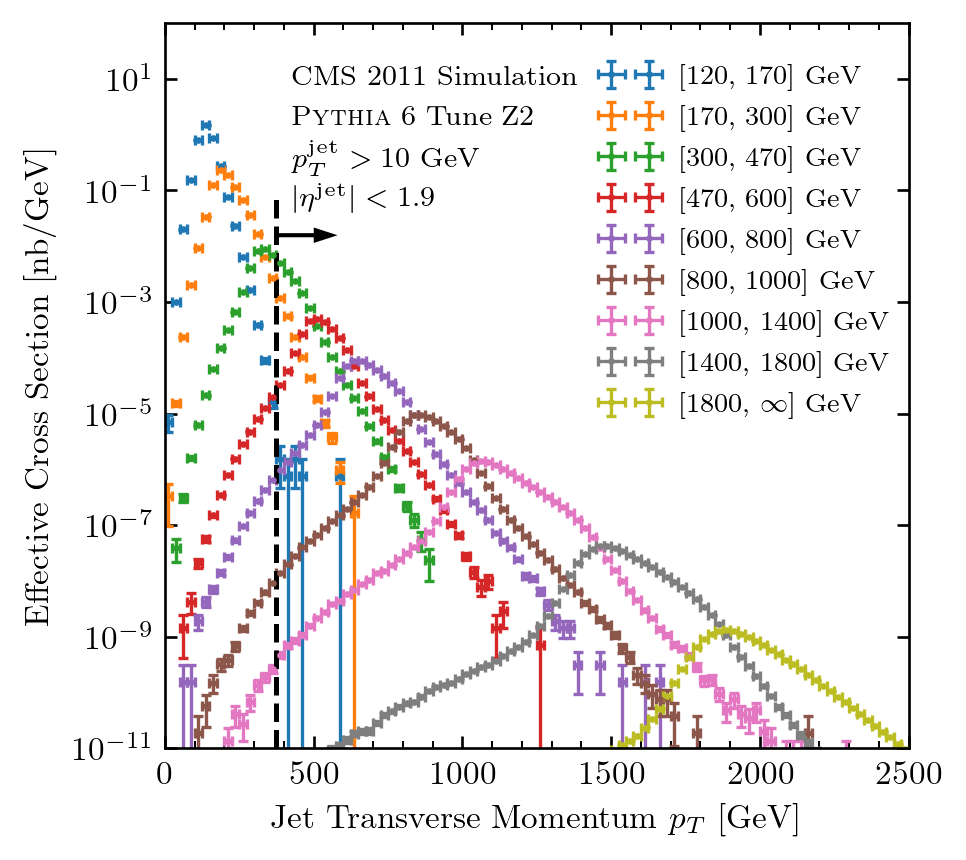

In [51]:
fig, axes = modplot.axes(ratio_plot=False, 
                         xlim=(min(bins), max(bins)), ylim=(10**-11, 10**2),
                         xlabel=r'Jet Transverse Momentum $p_T$ [GeV]',
                         ylabel='Effective Cross Section [nb/GeV]')
ax = axes[0]
ax.set_yscale('log')

ptmins = list(eff_xs_hists.keys()) + [r'$\infty$']
for i,(hist, errs) in enumerate(eff_xs_hists.values()):
    ax.errorbar(midbins, hist, xerr=binwidth/2, yerr=errs,
                marker='o', ms=1, ls='none', elinewidth=1, capthick=1, capsize=1.5,
                label=r'[{}, {}] GeV'.format(ptmins[i], ptmins[i+1]))
    
ax.plot([375,375], [10**-11, 0.09], color='black', ls='--')
ax.arrow(375/2500, 0.7075, 0.075, 0, transform=ax.transAxes,
         length_includes_head=True, head_width=0.015, color='black')
    
# legend
ax.legend(loc=(0.575, 0.44), frameon=False, ncol=1, numpoints=2, fontsize=8)

# stamp
modplot.stamp(0.17, 0.925, delta_y=0.055,
              line_0='CMS 2011 Simulation', 
              line_1=r'\textsc{Pythia} 6 Tune Z2', 
              line_2=r'$p_T^{\rm jet}>10$ GeV',
              line_3=r'$|\eta^{\rm jet}|<1.9$')

if save:
    modplot.save(fig, 'SIM_EffectiveCrossSectionByPt', tx=48.5, ty=252, out_plots_dir='../plots/Triggers')

fig.show()

## CMS Trigger Turn On Curves

In [52]:
# load in saved trigger info
trigsbypt = np.load(utils.path('cms', 'plotdata/TriggersByPtHardestJet.npz'))
fireds, prescales, jet_pts = trigsbypt['fireds'], trigsbypt['prescales'], trigsbypt['jet_pts']

In [53]:
# pt bins
bins_low = np.linspace(0, 600, 61)
bins = np.linspace(0, 600, 121)
start = time.time()

# get bin indices
pt_bin_inds_low = np.digitize(jet_pts, bins=bins_low)
pt_bin_inds = np.digitize(jet_pts, bins=bins)
print('Digitized in {:.3f}s'.format(time.time() - start))

def make_cms_trig_turnon_curve(i, reg=10**-30):
    
    # indices for low and high triggers
    low, high = i, i+1
    
    # masks for which jets had the low and high trigger firing
    low_fired_mask, high_fired_mask = fireds[:,low], fireds[:,high]
    
    # mask for when the high trigger was present
    high_present_mask = (prescales[:,high] > 0.)
    
    # if trig is one of the ones with common L1, use GCD formula, else 1/prescale_high
    if jet_trig_names[high] in {'HLT_Jet190', 'HLT_Jet240', 'HLT_Jet300', 'HLT_Jet370'}:
        weights = np.asarray([math.gcd(h,l)/h for h,l in zip(prescales[:,high], prescales[:,low])])
    else:
        weights = 1/prescales[:,high]
        
    # iterate over bins:
    trig_turnon = []
    bins_local = bins_low if i < 3 else bins
    pt_bin_inds_local = pt_bin_inds_low if i < 3 else pt_bin_inds
    for bin_i in range(1, len(bins_local)):
        
        # get bin mask
        bin_mask = (pt_bin_inds_local == bin_i)
        
        # get quantities for this bin
        low_fired_bin_i = low_fired_mask[bin_mask]
        high_fired_bin_i = high_fired_mask[bin_mask]
        high_present_bin_i = high_present_mask[bin_mask]
        weights_bin_i = weights[bin_mask]
        
        # construct masks where low was present and high trigger did and did not fire
        yes_mask = low_fired_bin_i & high_fired_bin_i
        no_mask = low_fired_bin_i & high_present_bin_i & ~high_fired_bin_i
        
        # construct quantities
        Y = np.count_nonzero(yes_mask)
        Yw, Nw = np.sum(weights_bin_i[yes_mask]), np.sum(weights_bin_i[no_mask])
        Yww, Nww = np.sum(weights_bin_i[yes_mask]**2), np.sum(weights_bin_i[no_mask]**2)
        
        # get the central value
        rate = Y/(Yw + Nw + reg)
        
        # get the error
        err = Y/(Yw + Nw + reg)**2*np.sqrt(Yww + Nww + (Nw**2 - Yw**2)/(Y + reg))
        
        # append answer
        trig_turnon.append([rate, err])

    # return turnon curve
    return np.asarray(trig_turnon, dtype=float)

ncurves = len(jet_trig_names) - 1
with multiprocessing.Pool(ncurves) as pool:
    turnon_curves = pool.map(make_cms_trig_turnon_curve, range(ncurves), chunksize=1)
    print('Computed curves in {:.3f}s'.format(time.time() - start))
    
trig_turnons = {name: turnon_curves[i] for i,name in enumerate(jet_trig_names[1:])}

if save:
    fp = utils.path('cms', 'plotdata/TriggerTurnOnHardestJet.npz')
    print('Saved to', fp)
    np.savez(fp, bins=bins, bins_low=bins_low, **trig_turnons)

Digitized in 2.589s
Computed curves in 49.857s
Saved to /disk0/CMS2011AJets/JetPrimaryDataset/plotdata/TriggerTurnOnHardestJet.npz


In [35]:
# load saved turn on curves
f = np.load(utils.path('cms', 'plotdata/TriggerTurnOnHardestJet.npz'))
trig_turnons = {name: f[name] for name in jet_trig_names[1:]}
bins, bins_low = f['bins'], f['bins_low']

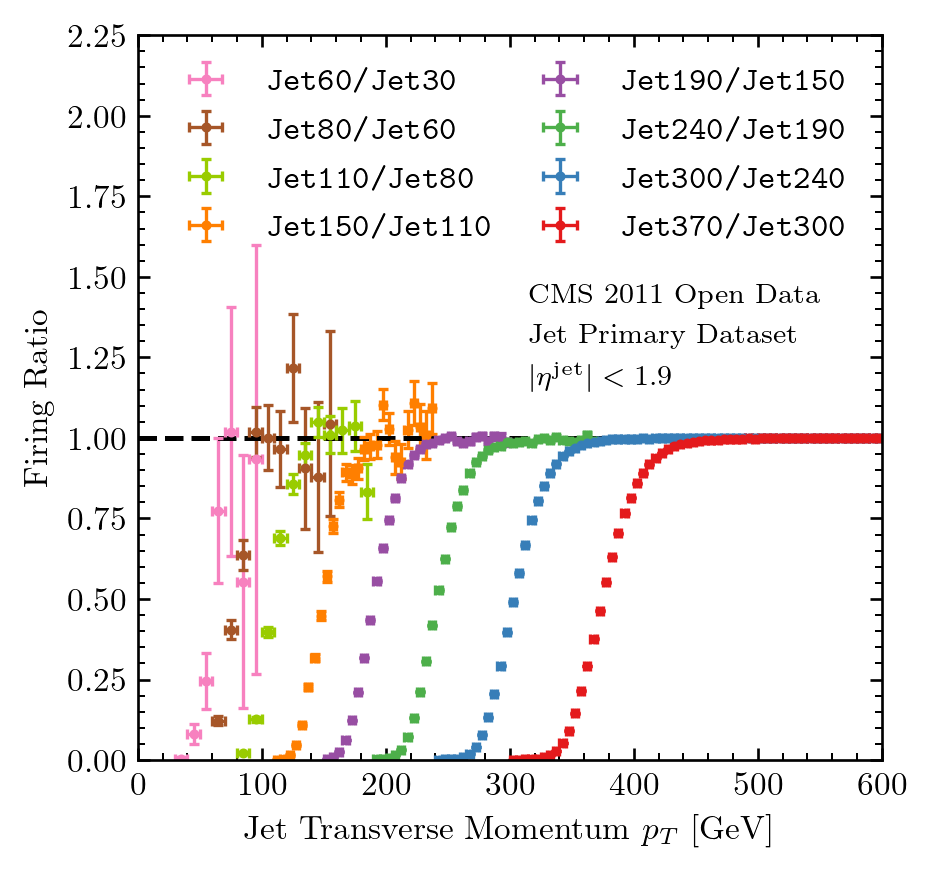

In [36]:
# middle of the pt bins
midbins = (bins[1:] + bins[:-1])/2
midbins_low = (bins_low[1:] + bins_low[:-1])/2

# range to plot for given trigger
xrange = {'HLT_Jet60':  (30, 100), 'HLT_Jet80':  (60, 160), 
          'HLT_Jet110': (80, 190), 'HLT_Jet150': (110, 240), 
          'HLT_Jet190': (150, 300), 'HLT_Jet240': (190, 370), 
          'HLT_Jet300': (240, max(bins)), 'HLT_Jet370': (300, max(bins))}

fig, axes = modplot.axes(ratio_plot=False, 
                         xlim=(min(bins), max(bins)), ylim=(0, 2.25),
                         xlabel=r'Jet Transverse Momentum $p_T$ [GeV]',
                         ylabel='Firing Ratio')
ax = axes[0]

# plot horizontal line
ax.plot([min(bins), max(bins)], [1, 1], '--', color='black', lw=1.5)

# iterate over tirggers and plot them
for i,name in enumerate(jet_trig_names[1:]):
    midbins_local = midbins_low if i < 3 else midbins
    
    mask = (xrange[name][0] <= midbins_local) & (midbins_local <= xrange[name][1])
    rates, errs = trig_turnons[name][mask,0], trig_turnons[name][mask,1]
    ax.errorbar(midbins_local[mask], rates, yerr=errs, xerr=(midbins_local[1] - midbins_local[0])/2, 
                marker='o', ms=2, ls='none', elinewidth=1, capthick=1, capsize=1.5,
                label=r'\tt {}/{}'.format(name[4:], jet_trig_names[i][4:]), color=trigger_colors[name])

# legend
ax.legend(loc='upper center', frameon=False, ncol=2, columnspacing=1)

# stamp
modplot.stamp(0.525, 0.64, delta_y=0.055,
              line_0='CMS 2011 Open Data', 
              line_1='Jet Primary Dataset',
              line_2=r'$|\eta^{\rm jet}|<1.9$')

if save:
    modplot.save(fig, 'CMS_TriggerTurnOnHardestJet', 
                 tx=40.5, ty=252, out_plots_dir='../plots/Triggers')

fig.show()

## CMS Jet300 ERF Fit

In [37]:
def erf(z, a, b):
    return scipy.special.erf(z/a + b)

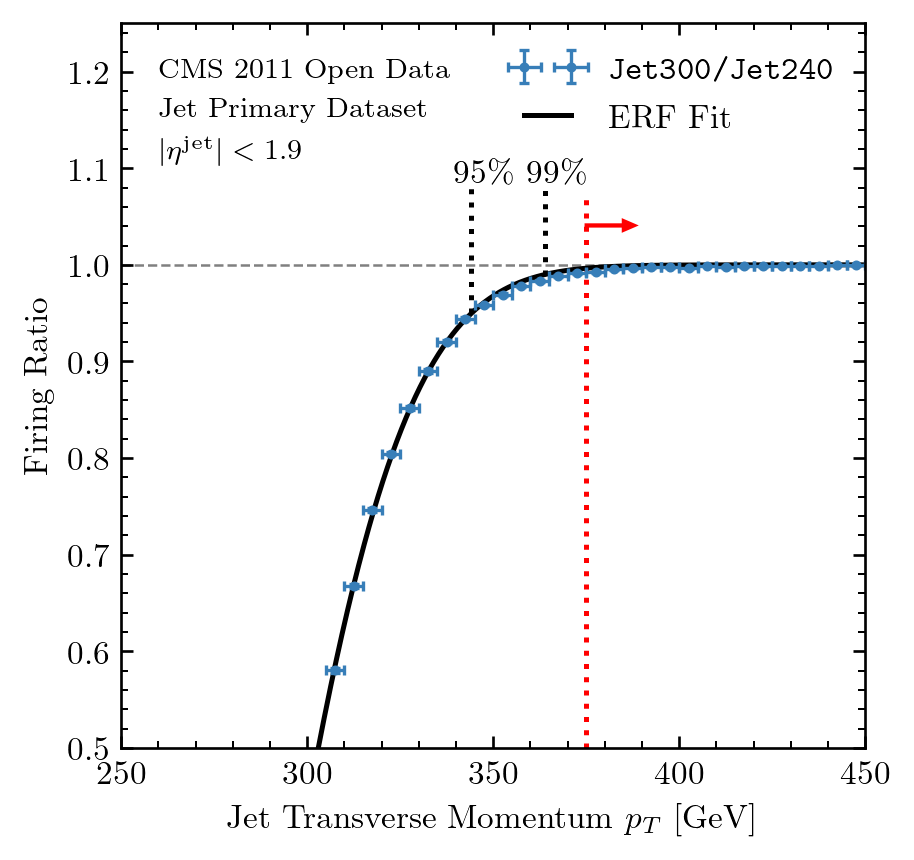

In [38]:
fig, axes = modplot.axes(ratio_plot=False, 
                         xlim=(250, 450), ylim=(0.5, 1.25),
                         xlabel=r'Jet Transverse Momentum $p_T$ [GeV]',
                         ylabel='Firing Ratio')
name = 'HLT_Jet300'

mask = (300 <= midbins) & (midbins <= 450)
rates, errs = trig_turnons[name][mask,0], trig_turnons[name][mask,1]

axes[0].errorbar(midbins[mask], rates, yerr=errs, xerr=(bins[1] - bins[0])/2, 
            marker='o', ms=2, ls='none', elinewidth=1, capthick=1, capsize=1.5,
            label=r'\tt Jet300/Jet240', color=trigger_colors[name])

popt, pcov = scipy.optimize.curve_fit(erf, midbins[mask], rates, p0=(400,1))

lcolor = 'black'
xs = np.linspace(250, 500, 1000)
ys = erf(xs, a=popt[0], b=popt[1])
axes[0].plot(xs, ys, lw=1.5, color=lcolor, zorder=-1, label='ERF Fit')

# put a marker at the 95th percentile
i0 = np.argmin(np.abs(ys-0.95))
axes[0].plot([xs[i0], xs[i0]], [ys[i0],1.08], color=lcolor, ls=':', zorder=-3)
axes[0].text(xs[i0]-5, 1.085, r'95\%', color=lcolor)

# put a marker at the 99th percentile
i0 = np.argmin(np.abs(ys-0.99))
axes[0].plot([xs[i0], xs[i0]], [ys[i0],1.08], color=lcolor, ls=':', zorder=-3)
axes[0].text(xs[i0]-5, 1.085, r'99\%', color=lcolor)

plt.plot(xs, 1+0*xs, '--', lw=0.75, color='gray', zorder=-2)

# arrow for pT selection
axes[0].plot([375, 375], [0.5,1.075], color='red', ls=':', zorder=-3)
axes[0].arrow(375, 1.04075, 10, 0, head_width=0.01, head_length=3, edgecolor=None, color='red')

# legend
modplot.legend(ax=axes[0], order=[1,0], loc='upper right', frameon=False, ncol=1, columnspacing=1)

# stamp
modplot.stamp(0.05, 0.93525, delta_y=0.055, ax=axes[0],
              line_0='CMS 2011 Open Data', 
              line_1='Jet Primary Dataset',
              line_2=r'$|\eta^{\rm jet}|<1.9$')

if save:
    modplot.save(fig, 'CMS_Jet300TurnOnHardestJet', 
                 tx=35.2, ty=252, out_plots_dir='../plots/Triggers')

fig.show()

In [39]:
errs

array([0.00213116, 0.00221514, 0.00221268, 0.00214771, 0.00204638,
       0.00192011, 0.00178543, 0.00161908, 0.00143083, 0.0013087 ,
       0.00118086, 0.0010425 , 0.00096405, 0.00083006, 0.00076349,
       0.00071905, 0.00060322, 0.00056571, 0.00046509, 0.00051599,
       0.00061   , 0.00039472, 0.00054441, 0.00046131, 0.00049721,
       0.00043684, 0.00040461, 0.00038692, 0.        , 0.00032229])

## SIM Trigger Turn On Curves

In [53]:
sim_trs = np.load(utils.path('sim', 'plotdata/TriggersByPtHardestJet.pickle'), allow_pickle=True)
sim_jet_trig_names = jet_trig_names[:2] + [jet_trig_names[3]] + jet_trig_names[5:]
use120 = True

In [54]:
# pt bins
sim_bins = np.linspace(0, 600, 121)

# digitize
for ptmin in sim_trs:
    sim_trs[ptmin]['digits'] = np.digitize(sim_trs[ptmin]['jet_pts'], bins=sim_bins)

# weights
sim_xs = np.load(utils.path('sim', 'CrossSections.pickle'), allow_pickle=True)
sim_weights = {ptmin: sim_xs[ptmin]['xs']/sim_xs[ptmin]['nev']/10**3 for ptmin in sim_xs}

In [55]:
reg = 10**-30
sim_turnons = {}
for jet_tn in sim_jet_trig_names:
    i = jet_trig_names.index(jet_tn)
    start = time.time()
    l = len(sim_bins)-1
    sim_turnons[jet_tn] = {'fired_weights': [[] for i in range(l)], 'present_weights': [[] for i in range(l)]}
    
    for ptmin in sim_trs:
        if not use120 and ptmin == '120':
            continue

        digits, fireds = sim_trs[ptmin]['digits'], sim_trs[ptmin]['fireds'][:,i]
        weight = sim_weights[ptmin]
        
        for j in range(1, len(sim_bins)):
            fireds_bin = fireds[digits==j]
            sim_turnons[jet_tn]['fired_weights'][j-1].extend(np.count_nonzero(fireds_bin)*[weight])
            sim_turnons[jet_tn]['present_weights'][j-1].extend(len(fireds_bin)*[weight])
            
    
    fireds = np.asarray([sum(fws) for fws in sim_turnons[jet_tn]['fired_weights']])
    presents = np.asarray([sum(pws) for pws in sim_turnons[jet_tn]['present_weights']])
    no_fireds = presents - fireds
    fired_stds = np.asarray([np.linalg.norm(fws) for fws in sim_turnons[jet_tn]['fired_weights']])
    present_stds = np.asarray([np.linalg.norm(pws) for pws in sim_turnons[jet_tn]['present_weights']])
    no_fired_stds = np.sqrt(present_stds**2 - fired_stds**2)
    
    sim_turnons[jet_tn]['rates'] = fireds/(presents + reg)
    sim_turnons[jet_tn]['errs'] = no_fireds/(presents + reg)*np.sqrt((no_fired_stds/(no_fireds + reg))**2 +
                                                                     (present_stds/(presents + reg))**2)
        
    print('Finished {} in {:.3f}s'.format(jet_tn, time.time() - start))

Finished HLT_Jet30 in 13.825s
Finished HLT_Jet60 in 14.445s
Finished HLT_Jet110 in 14.575s
Finished HLT_Jet190 in 12.975s
Finished HLT_Jet240 in 12.301s
Finished HLT_Jet300 in 11.825s
Finished HLT_Jet370 in 11.488s


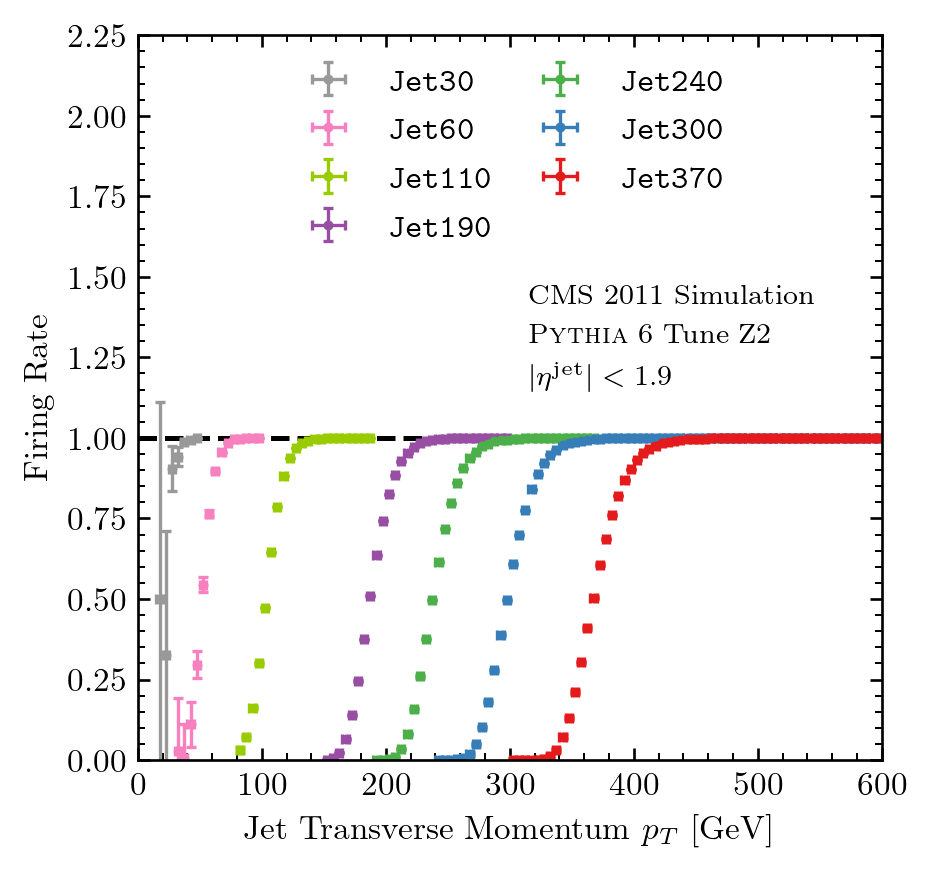

In [56]:
# middle of the pt bins
sim_midbins = (sim_bins[1:] + sim_bins[:-1])/2

# range to plot for given trigger
xrange = {'HLT_Jet30': (15, 50),
          'HLT_Jet60':  (30, 100), 'HLT_Jet110': (80, 190), 
          'HLT_Jet190': (150, 300), 'HLT_Jet240': (190, 370), 
          'HLT_Jet300': (240, max(sim_bins)), 'HLT_Jet370': (300, max(sim_bins))}

fig, axes = modplot.axes(ratio_plot=False, 
                         xlim=(min(sim_bins), max(sim_bins)), ylim=(0, 2.25),
                         xlabel=r'Jet Transverse Momentum $p_T$ [GeV]',
                         ylabel='Firing Rate')
ax = axes[0]

# plot horizontal line
ax.plot([min(sim_bins), max(sim_bins)], [1, 1], '--', color='black', lw=1.5)

# iterate over tirggers and plot them
for i,name in enumerate(sim_jet_trig_names):    
    mask = (xrange[name][0] <= sim_midbins) & (sim_midbins <= xrange[name][1])
    rates, errs = sim_turnons[name]['rates'][mask], sim_turnons[name]['errs'][mask]
    ax.errorbar(sim_midbins[mask], rates, yerr=errs, xerr=(sim_midbins[1] - sim_midbins[0])/2, 
                marker='o', ms=2, ls='none', elinewidth=1, capthick=1, capsize=1.5,
                label=r'\tt {}'.format(name[4:]), color=trigger_colors[name])

# legend
ax.legend(loc='upper center', frameon=False, ncol=2, columnspacing=1)

# stamp
modplot.stamp(0.525, 0.64, delta_y=0.055,
              line_0='CMS 2011 Simulation', 
              line_1=r'\textsc{Pythia} 6 Tune Z2',
              line_2=r'$|\eta^{\rm jet}|<1.9$')

if save:
    modplot.save(fig, 'SIM_TriggerTurnOnHardestJet' + ('_with120' if use120 else ''), 
                 tx=40.5, ty=252, out_plots_dir='../plots/Triggers')

fig.show()

## SIM Jet300 ERF Fit

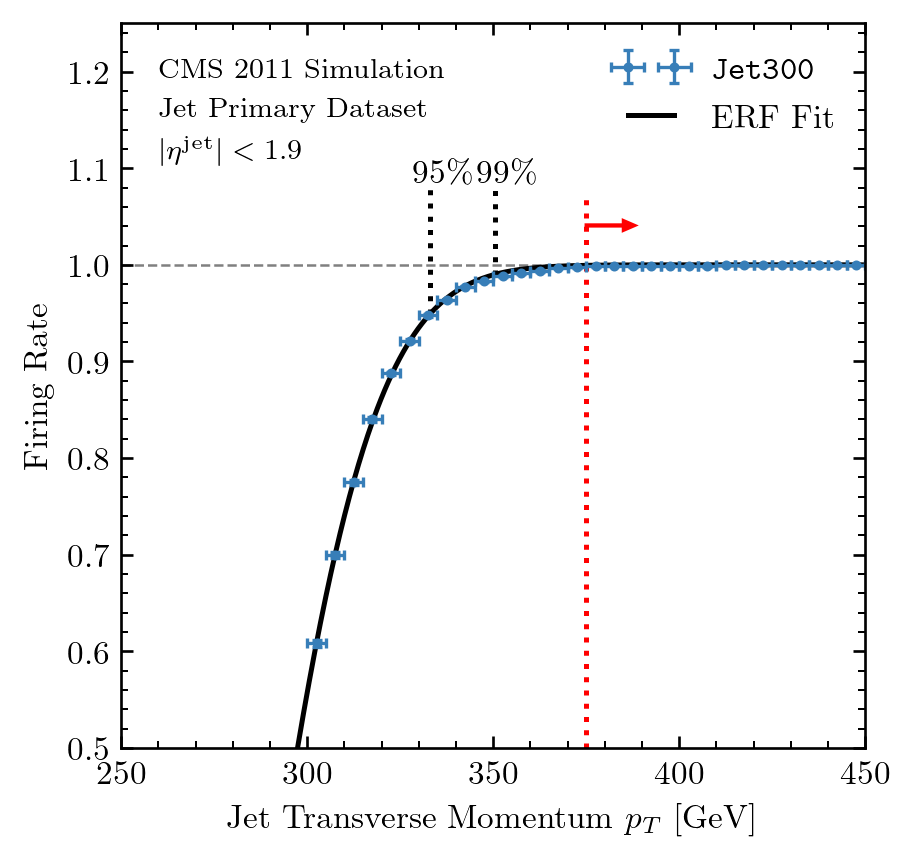

In [57]:
fig, axes = modplot.axes(ratio_plot=False, 
                         xlim=(250, 450), ylim=(0.5, 1.25),
                         xlabel=r'Jet Transverse Momentum $p_T$ [GeV]',
                         ylabel='Firing Rate')
name = 'HLT_Jet300'

mask = (300 <= sim_midbins) & (sim_midbins <= 450)
rates, errs = sim_turnons[name]['rates'][mask], sim_turnons[name]['errs'][mask]

axes[0].errorbar(sim_midbins[mask], rates, yerr=errs, xerr=(sim_bins[1] - sim_bins[0])/2, 
            marker='o', ms=2, ls='none', elinewidth=1, capthick=1, capsize=1.5,
            label=r'\tt Jet300', color=trigger_colors[name])

popt, pcov = scipy.optimize.curve_fit(erf, sim_midbins[mask], rates, p0=(400,1))

lcolor = 'black'
xs = np.linspace(250, 500, 1000)
ys = erf(xs, a=popt[0], b=popt[1])
axes[0].plot(xs, ys, lw=1.5, color=lcolor, zorder=-1, label='ERF Fit')

# put a marker at the 95th percentile
i0 = np.argmin(np.abs(ys-0.95))
axes[0].plot([xs[i0], xs[i0]], [ys[i0],1.08], color=lcolor, ls=':', zorder=-3)
axes[0].text(xs[i0]-5, 1.085, r'95\%', color=lcolor)

# put a marker at the 99th percentile
i0 = np.argmin(np.abs(ys-0.99))
axes[0].plot([xs[i0], xs[i0]], [ys[i0],1.08], color=lcolor, ls=':', zorder=-3)
axes[0].text(xs[i0]-5, 1.085, r'99\%', color=lcolor)

plt.plot(xs, 1+0*xs, '--', lw=0.75, color='gray', zorder=-2)

# arrow for pT selection
axes[0].plot([375, 375], [0.5,1.075], color='red', ls=':', zorder=-3)
axes[0].arrow(375, 1.04075, 10, 0, head_width=0.01, head_length=3, edgecolor=None, color='red')

# legend
modplot.legend(ax=axes[0], order=[1,0], loc='upper right', frameon=False, ncol=1, columnspacing=1)

# stamp
modplot.stamp(0.05, 0.93525, delta_y=0.055, ax=axes[0],
              line_0='CMS 2011 Simulation', 
              line_1='Jet Primary Dataset',
              line_2=r'$|\eta^{\rm jet}|<1.9$')

if save:
    modplot.save(fig, 'SIM_Jet300TurnOnHardestJet' + ('_with120' if use120 else ''),
                 tx=35.2, ty=252, out_plots_dir='../plots/Triggers')

fig.show()